# Section 4.5 — Model selection

This notebook contains the code examples from [Section 4.5 Model selection]() from the **No Bullshit Guide to Statistics**.

#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn't work
from plot_helpers import RCPARAMS
# RCPARAMS.update({'figure.figsize': (10, 3)})   # good for screen
RCPARAMS.update({'figure.figsize': (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# High-resolution please
%config InlineBackend.figure_format = 'retina'

# Where to store figures
DESTDIR = "figures/lm/generalized"

<Figure size 640x480 with 0 Axes>

In [3]:
# set random seed for repeatability
np.random.seed(42)


## Players dataset

In [4]:
players_full = pd.read_csv("../datasets/players_full.csv")

### Plot of linear model for `time ~ 1 + age`

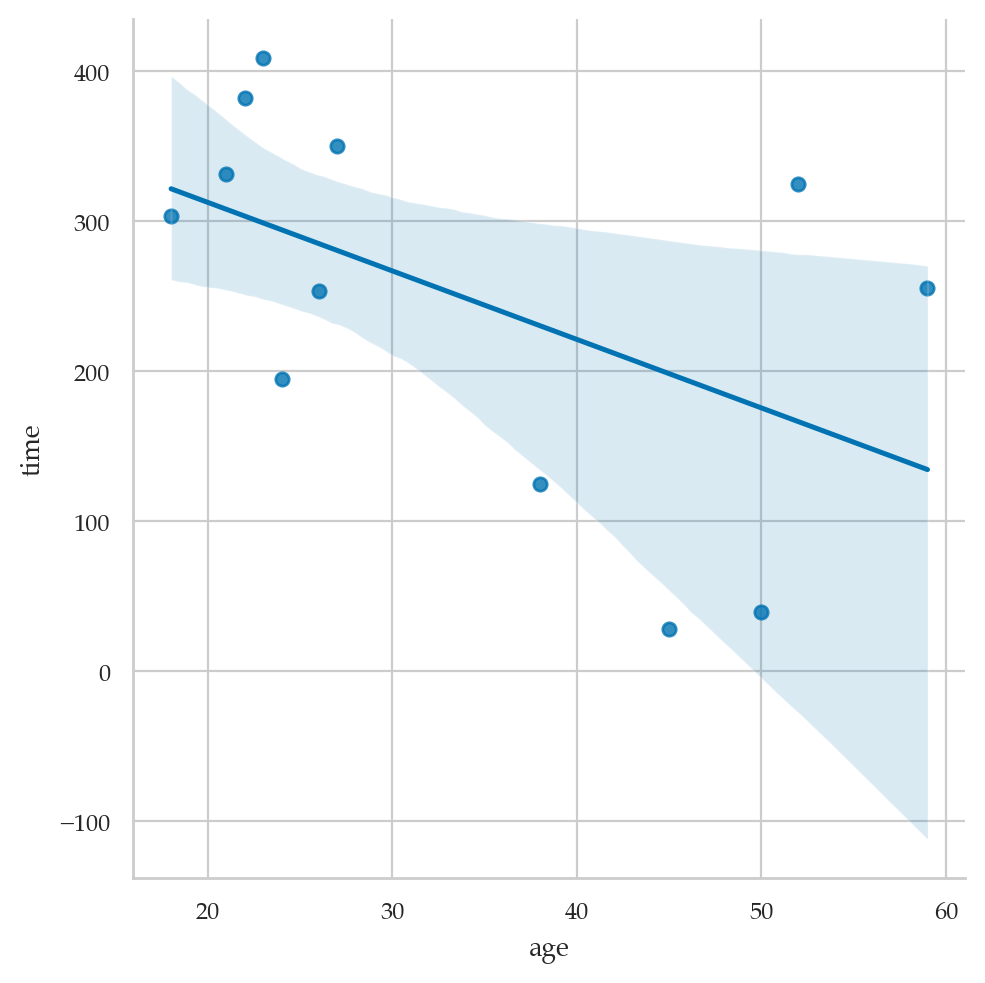

In [5]:
sns.lmplot(x="age", y="time", data=players_full)

In [6]:
import statsmodels.formula.api as smf

model1 = smf.ols('time ~ 1 + age', data=players_full)
result1 = model1.fit()
result1.summary()

/Users/ivan/Projects/Minireference/STATSbook/noBSstatsnotebooks/venv/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     3.516
Date:                Sun, 10 Mar 2024   Prob (F-statistic):             0.0902
Time:                        23:29:40   Log-Likelihood:                -72.909
No. Observations:                  12   AIC:                             149.8
Df Residuals:                      10   BIC:                             150.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    403.8531     88.666      4.555      0.001     206.292     601.414
age           -4.5658      2.435     -1.875      0.090      -9.991       0.859
==============================================================================
Omnibus:                        2.175   Durbin-Watson:                   2.490
Prob(Omnibus):                  0.337   Jarque-Bera (JB):                0.930
Skew:                          -0.123   Prob(JB):                        0.628
Kurtosis:                       1.659   Cond. No.                         97.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Plot of linear model for `time ~ 1 + age + jobstatus`

We can "control for `jobstatus`" by including the variable in the linear model.
Essentially,
we're fitting two separate models,
one for `jobstatus=0` players and one for `jobstatus=1` players.


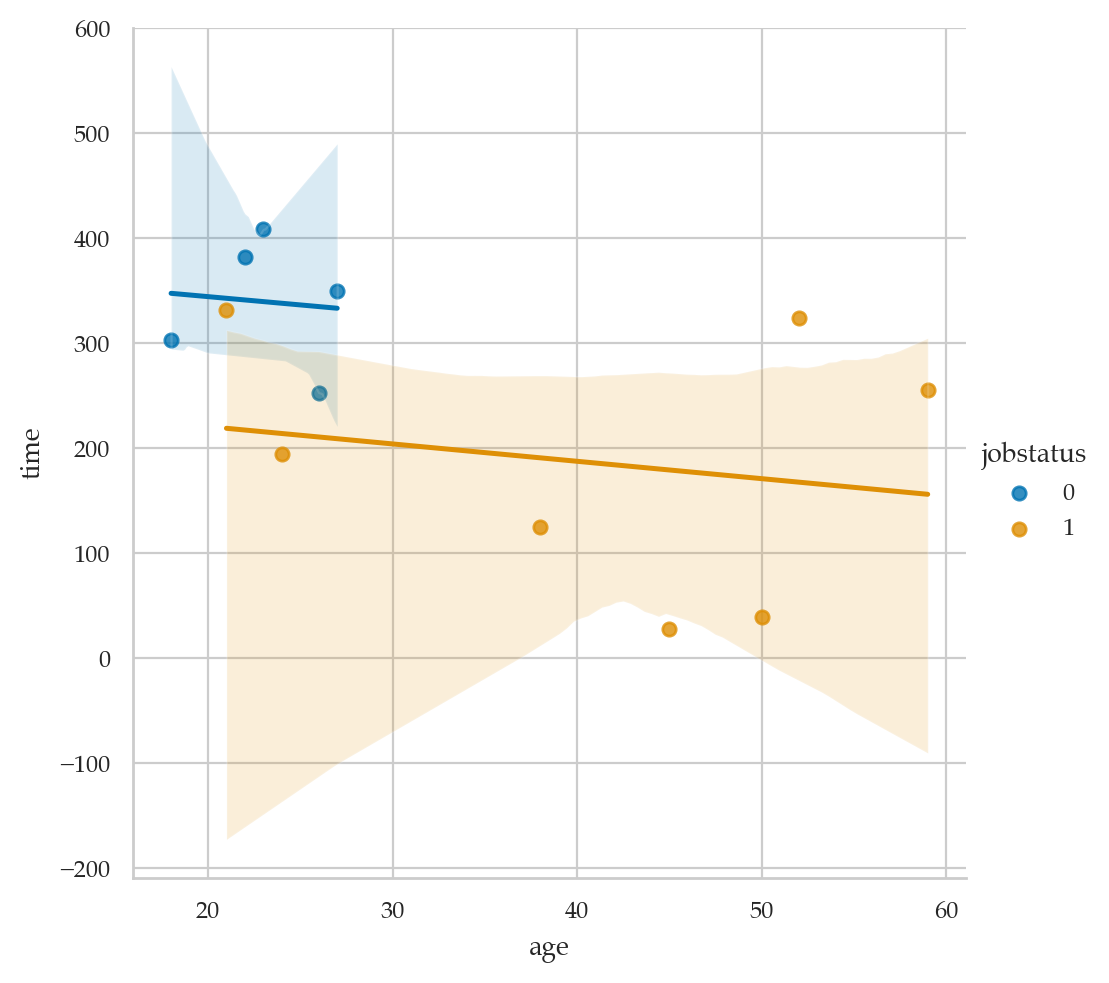

In [7]:
sns.lmplot(x="age", y="time", hue="jobstatus", data=players_full)

In [8]:
import statsmodels.formula.api as smf

model2 = smf.ols('time ~ 1 + age + C(jobstatus)', data=players_full)
result2 = model2.fit()
result2.params
# print(result2.summary().as_text())

Intercept            377.817172
C(jobstatus)[T.1]   -124.013781
age                   -1.650913
dtype: float64

#### Manual select subset with jobstatus 1

In [9]:
# import statsmodels.formula.api as smf

# players_job1 = players_full[players_full["jobstatus"]==1]
# model3 = smf.ols('time ~ 1 + age', data=players_job1)
# result3 = model3.fit()
# result3.summary()

### Example confoudouder  2

via https://stats.stackexchange.com/a/17338/62481

In [10]:
import numpy as np
from scipy.stats import uniform, randint

covariate = randint(0,2).rvs(100)
exposure  = uniform(0,1).rvs(100) +  0.3 * covariate
outcome   = 2.0 + 0.5*exposure + 0.25*covariate

# covariate, exposure, outcome
df2 = pd.DataFrame({
    "covariate":covariate,
    "exposure":exposure,
    "outcome":outcome
})

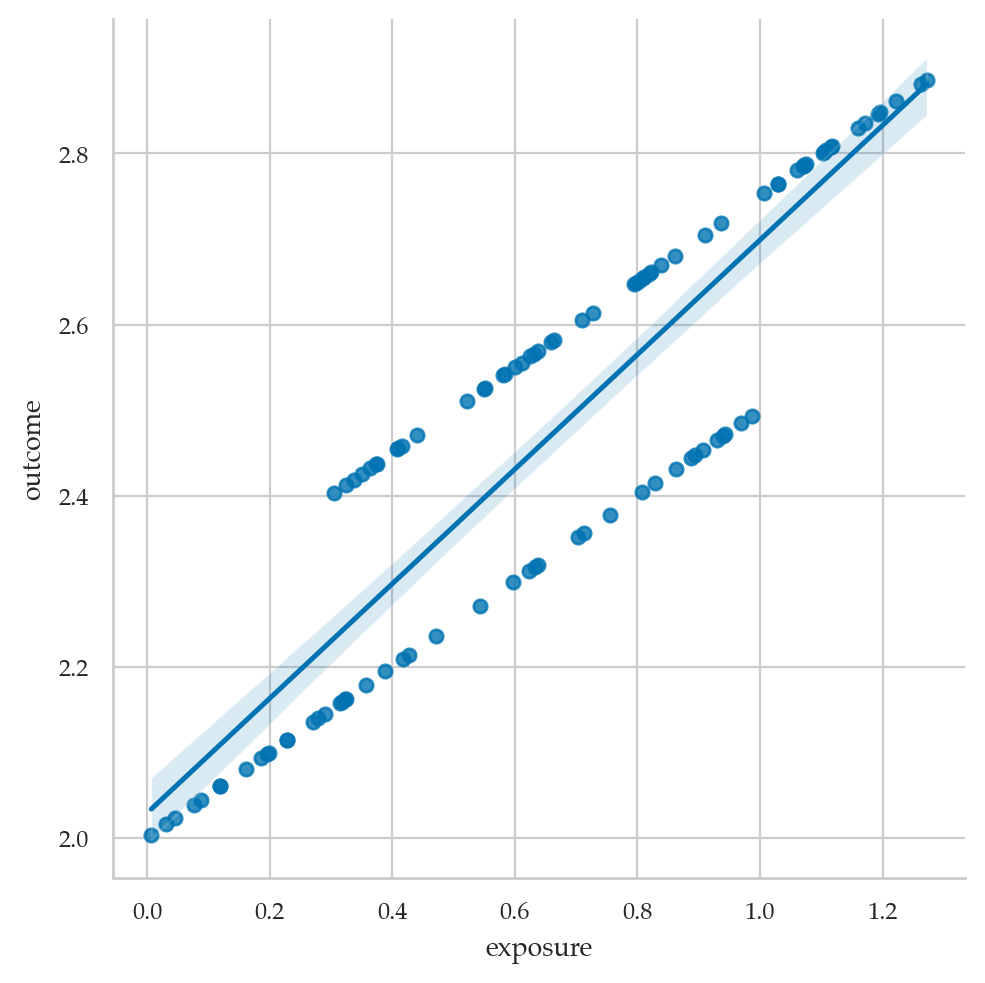

In [11]:
sns.lmplot(x="exposure", y="outcome", data=df2)

In [12]:
import statsmodels.formula.api as smf

model2a = smf.ols('outcome ~ exposure', data=df2)
result2a = model2a.fit()
# result2a.summary()
result2a.params

Intercept    2.028636
exposure     0.670186
dtype: float64

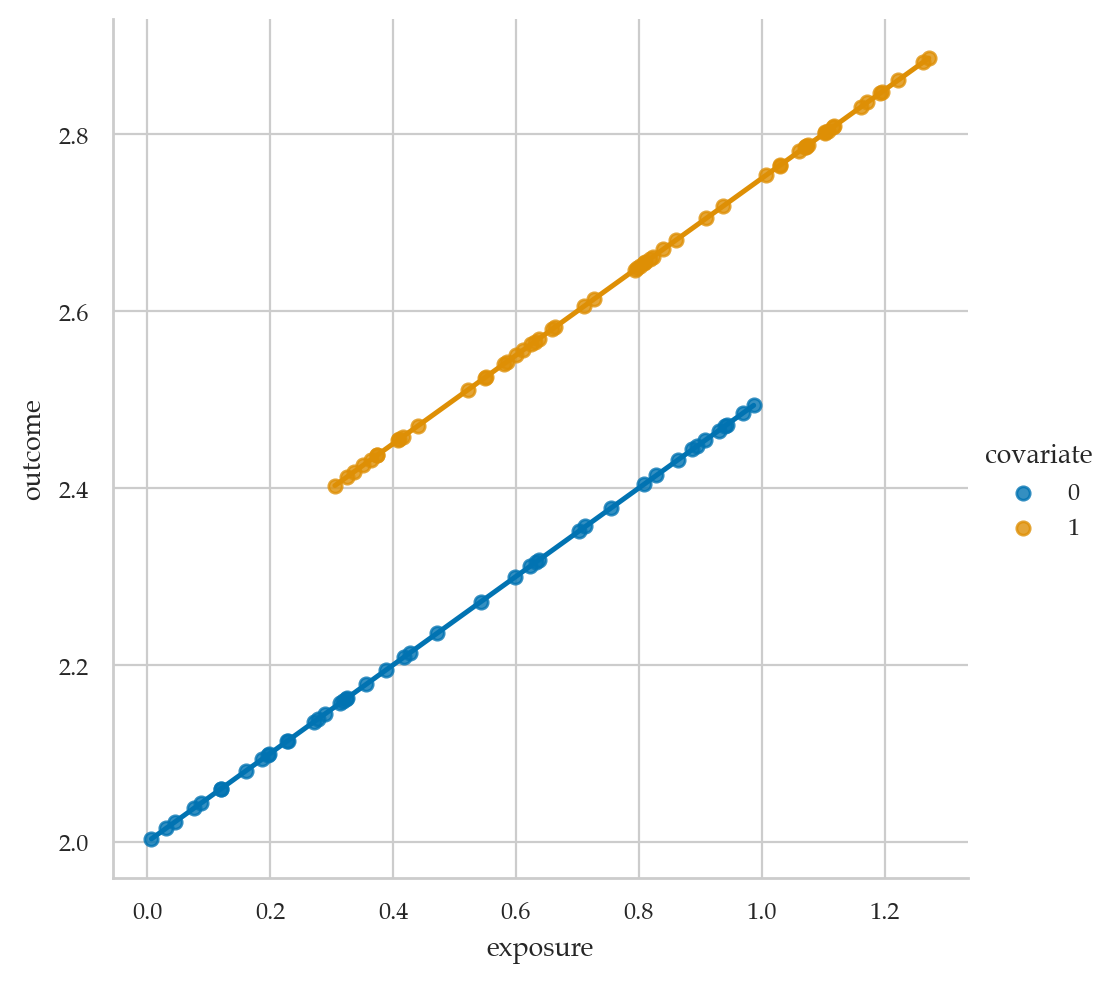

In [13]:
fg = sns.lmplot(x="exposure", y="outcome", hue="covariate", data=df2)

In [14]:
model2b = smf.ols('outcome ~ exposure + C(covariate)', data=df2)
result2b = model2b.fit()
# result2b.summary()
result2b.params

Intercept            2.00
C(covariate)[T.1]    0.25
exposure             0.50
dtype: float64

In [15]:
x = np.linspace(0,1.4)

m = result2b.params["exposure"]
b0 = result2b.params["Intercept"]
b1 = b0 + result2b.params["C(covariate)[T.1]"]

b0, b1

y0 = b0 + m*x
y1 = b1 + m*x
ax = fg.figure.axes[0]
sns.lineplot(x=x, y=y0, ax=ax, color="r")
sns.lineplot(x=x, y=y1, ax=ax, color="m")

<Axes: xlabel='exposure', ylabel='outcome'>

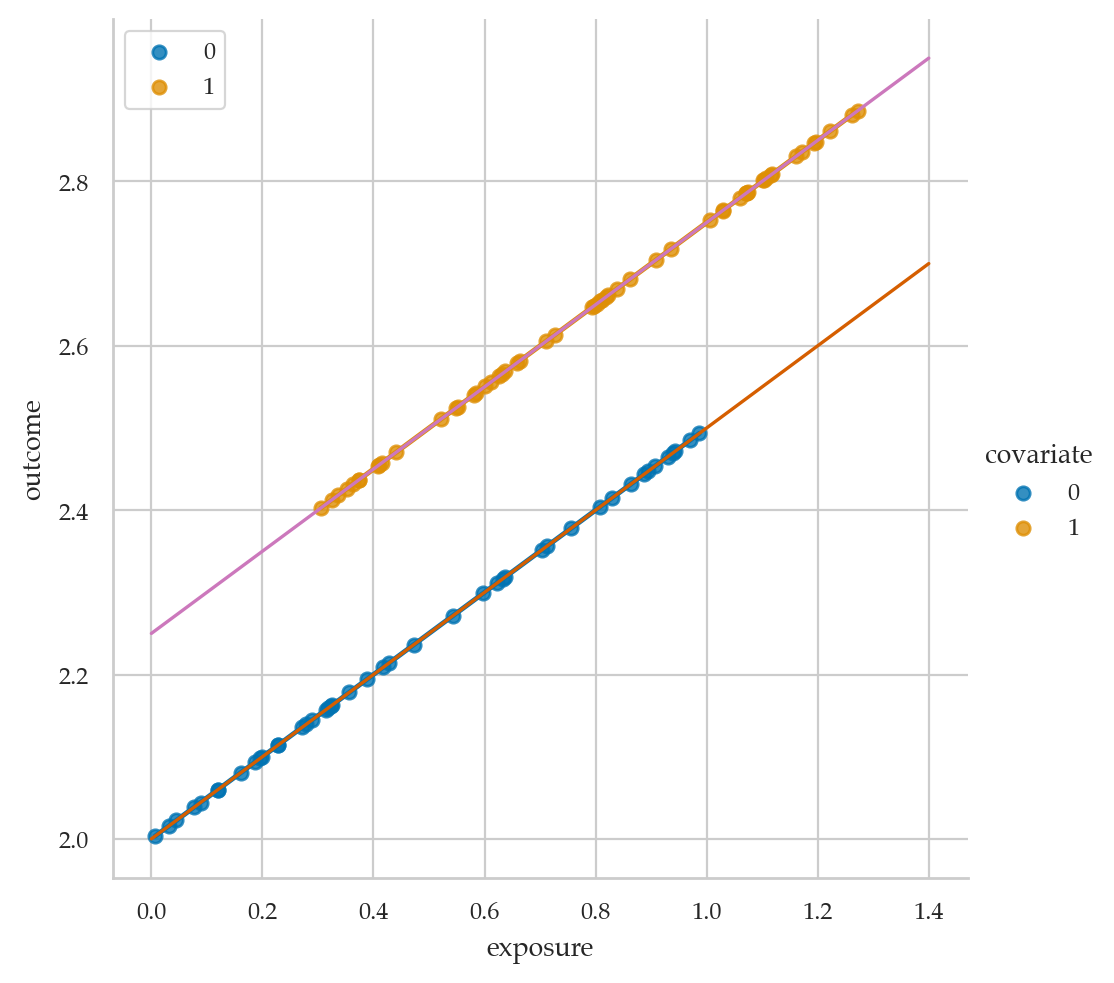

In [16]:
fg.figure

In [17]:
model2c = smf.ols('outcome ~ -1 + exposure*C(covariate)', data=df2)
result2c = model2c.fit()
result2c.summary()
# result2c.params

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.268e+31
Date:                Sun, 10 Mar 2024   Prob (F-statistic):               0.00
Time:                        23:29:44   Log-Likelihood:                 3403.7
No. Observations:                 100   AIC:                            -6799.
Df Residuals:                      96   BIC:                            -6789.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
C(covariate)[0]                2.0000   1.13e-16   1.77e+16      0.000       2.000       2.000
C(covariate)[1]                2.2500   1.58e-16   1.42e+16      0.000       2.250       2.250
exposure                       0.5000   1.99e-16   2.51e+15      0.000       0.500       0.500
exposure:C(covariate)[T.1]  6.661e-16   2.73e-16      2.438      0.017    1.24e-16    1.21e-15
==============================================================================
Omnibus:                        6.161   Durbin-Watson:                   0.975
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                4.722
Skew:                           0.414   Prob(JB):                       0.0943
Kurtosis:                       2.330   Cond. No.                         9.70
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# df = sns.load_dataset('iris')
# sns.regplot(x=df["sepal_length"], y=df["sepal_width"], line_kws={"color":"r","alpha":0.7,"lw":5})

### Random slopes and random intercepts

via https://patsy.readthedocs.io/en/latest/quickstart.html

You can even write interactions between categorical and numerical variables.
Here we fit two different slope coefficients for x1; one for the a1 group, and one for the a2 group:
`dmatrix("a:x1", data)`

This is what matches the seaborn plot when using `hue` as an extra variable

In [19]:
model2d = smf.ols('outcome ~ 1 + C(covariate) + C(covariate):exposure', data=df2)
result2d = model2d.fit()
# result2d.summary()
result2d.params

Intercept                   2.00
C(covariate)[T.1]           0.25
C(covariate)[0]:exposure    0.50
C(covariate)[1]:exposure    0.50
dtype: float64

In [20]:
import numpy as np
from scipy.stats import uniform, randint

covariate3 = randint(0,2).rvs(100)
exposure3  = uniform(0,1).rvs(100) +  0.3 * covariate
outcome3   = 2.0 + 0.25*covariate3 + (0.5 + 0.1*covariate3)*exposure3 
#                  \             /    \                  /
#                  different inst.      different slopes  

df3 = pd.DataFrame({
    "covariate":covariate3,
    "exposure":exposure3,
    "outcome":outcome3
})


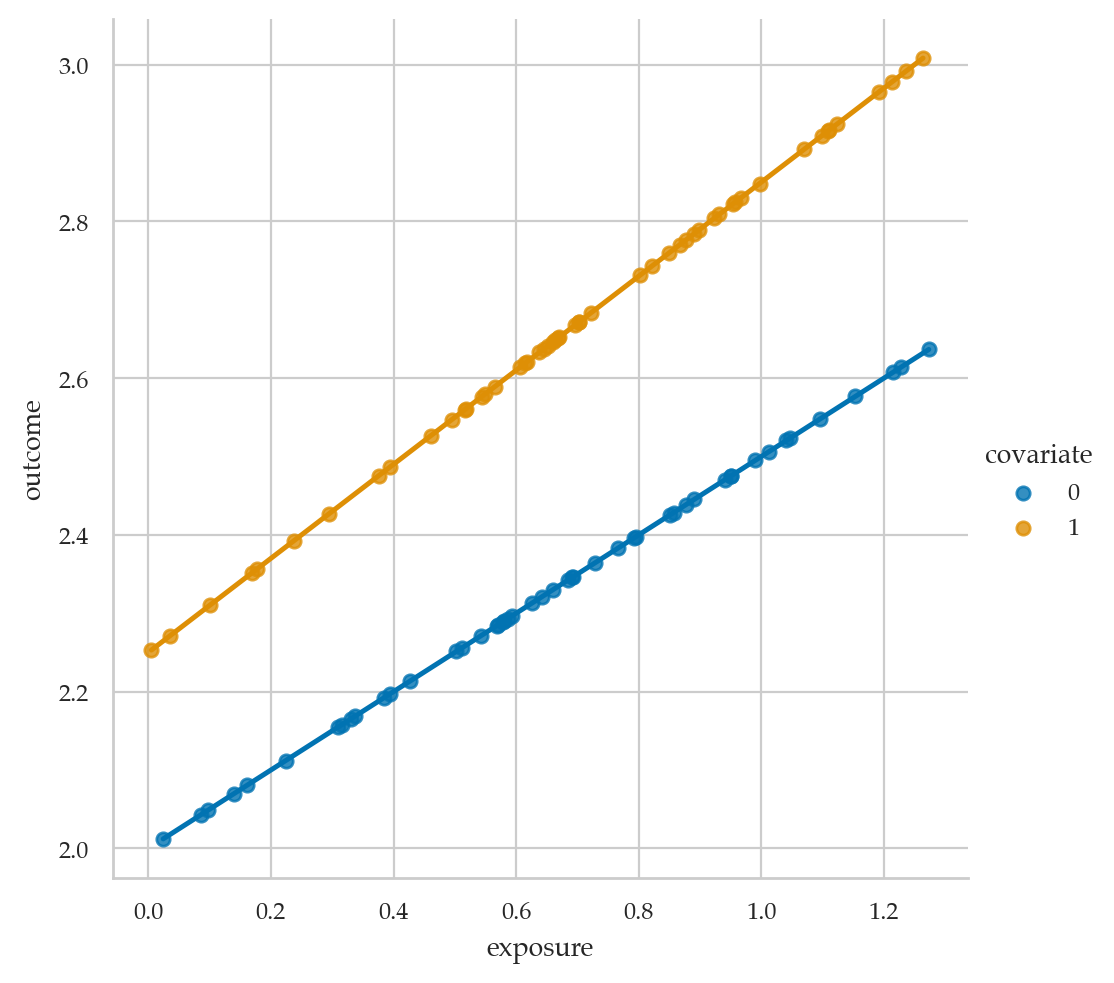

In [21]:
fg = sns.lmplot(x="exposure", y="outcome", hue="covariate", data=df3)

In [25]:
model3d = smf.ols('outcome ~ 1 + C(covariate) + C(covariate):exposure', data=df3)
result3d = model3d.fit()
result3d.params

Intercept                   2.00
C(covariate)[T.1]           0.25
C(covariate)[0]:exposure    0.50
C(covariate)[1]:exposure    0.60
dtype: float64

In [26]:
# ALT.
model3e = smf.ols('outcome ~ 0 + C(covariate) + C(covariate):exposure', data=df3)
result3e = model3e.fit()
result3e.params

C(covariate)[0]             2.00
C(covariate)[1]             2.25
C(covariate)[0]:exposure    0.50
C(covariate)[1]:exposure    0.60
dtype: float64